<a href="https://colab.research.google.com/github/JustynaMatewka/_Flower_Match_/blob/main/_Flower_match_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project \__Flower_match\__, flower species classification from image**

## Import and unzip database from kaggle.com

In [2]:
!pip install -q kaggle

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle

In [4]:
! chmod 600 /root/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d l3llff/flowers

Dataset URL: https://www.kaggle.com/datasets/l3llff/flowers
License(s): CC0-1.0
 97% 221M/228M [00:01<00:00, 190MB/s]
100% 228M/228M [00:01<00:00, 168MB/s]


In [6]:
!unzip "/content/flowers.zip" -d "/content/dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/flowers/magnolia/2090666304_0ff8463c5f_c.jpg  
  inflating: /content/dataset/flowers/magnolia/20914736071_ede33a230a_c.jpg  
  inflating: /content/dataset/flowers/magnolia/2126107417_92101f8b5f_c.jpg  
  inflating: /content/dataset/flowers/magnolia/21500695820_bc9f753d79_c.jpg  
  inflating: /content/dataset/flowers/magnolia/21986337916_36d1c95e64_c.jpg  
  inflating: /content/dataset/flowers/magnolia/2294580412_50846f9130_c.jpg  
  inflating: /content/dataset/flowers/magnolia/2300805045_982fa1bdf2_c.jpg  
  inflating: /content/dataset/flowers/magnolia/2306786428_99f92b0d9c_c.jpg  
  inflating: /content/dataset/flowers/magnolia/2324281515_c0269d5963_c.jpg  
  inflating: /content/dataset/flowers/magnolia/2325102200_1cb9d8cabc_c.jpg  
  inflating: /content/dataset/flowers/magnolia/2325102996_5f1e3bf13a_c.jpg  
  inflating: /content/dataset/flowers/magnolia/2325370643_f452e88ace_c.jpg  
  inflating: /content/

In [7]:
!rm -rf "/content/dataset/flowers/california_poppy"
!rm -rf "/content/dataset/flowers/astilbe"
!rm -rf "/content/dataset/flowers/calendula"
!rm -rf "/content/dataset/flowers/coreopsis"
!rm -rf "/content/dataset/flowers/iris"
!rm -rf "/content/dataset/flowers/dandelion"
!rm -rf "/content/dataset/flowers/daffodil"
!rm -rf "/content/dataset/flowers/black_eyed_susan"
!rm -rf "/content/dataset/flowers/carnation"
!rm -rf "/content/dataset/flowers/water_lily"
!rm -rf "/content/dataset/flowers/magnolia"
!rm -rf "/content/dataset/flowers/bellflower"

## Extensions

In [10]:
import tensorflow as tf
import pandas as pd   # reading and processing data
import seaborn as sns   # visualization
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Layer, GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy, TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers import L2, L1
from tensorflow.train import (Example, Features, Feature, BytesList, FloatList, Int64List)
from google.colab import drive

# Needed paths and names

In [11]:
directory = "/content/dataset/flowers"
result = ("/content/dataset/flowers/*")
CLASS_NAMES = []

for x in glob.glob(result):
   CLASS_NAMES.append(x.split("/")[-1])

CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IMAGE_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 10,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": len(CLASS_NAMES),
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": CLASS_NAMES,
}

# Dataset Loading

In [12]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IMAGE_SIZE"], CONFIGURATION["IMAGE_SIZE"]),
    shuffle=True,
    seed=99,
    validation_split=0.2,
    subset="training",
    interpolation='bilinear'
)

Found 4054 files belonging to 4 classes.
Using 3244 files for training.


In [13]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IMAGE_SIZE"], CONFIGURATION["IMAGE_SIZE"]),
    shuffle=True,
    seed=99,
    validation_split=0.2,
    subset="validation",
    interpolation='bilinear'
)

Found 4054 files belonging to 4 classes.
Using 810 files for validation.


# Dataset Visualization

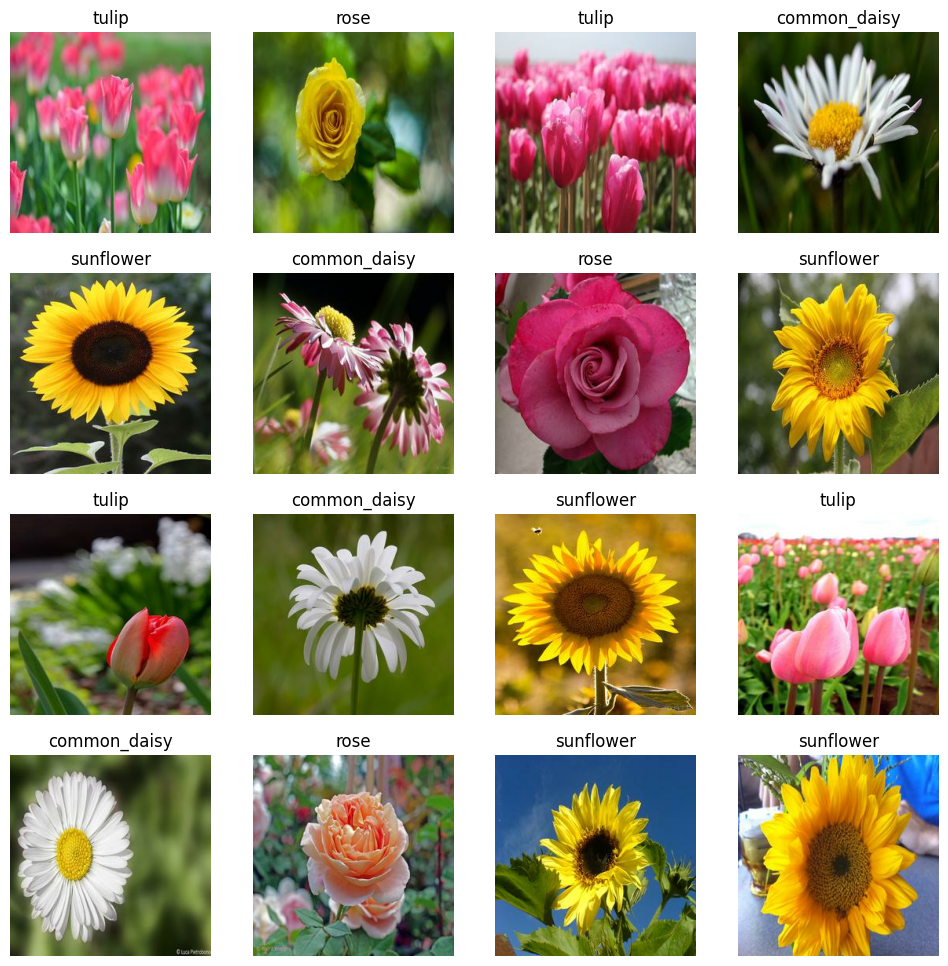

In [14]:
plt.figure(figsize = (12,12))

for image, labels in train_dataset.take(1):
  for x in range(16):
    ax = plt.subplot(4, 4, x+1)
    plt.imshow(image[x]/255.)
    plt.title(CLASS_NAMES[tf.argmax(labels[x], axis = 0).numpy()])
    plt.axis("off")
  break;

# Dataset Preparation

In [15]:
training_dataset = (
    train_dataset.prefetch(tf.data.AUTOTUNE)
)

In [16]:
validation_dataset = (
    val_dataset.prefetch(tf.data.AUTOTUNE)
)

In [17]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(CONFIGURATION["IMAGE_SIZE"], CONFIGURATION["IMAGE_SIZE"]),
    Rescaling(1./255),
])

# Modeling - ResNet with TF 2.0

# Custom Convolution 2D

In [18]:
class CustomConv2D(Layer):
  def __init__(self, n_filters, kernel_size, n_strides, padding = 'valid'):
    super(CustomConv2D, self).__init__(name = 'custom_conv2d')

    self.conv = Conv2D(
        filters = n_filters,
        kernel_size = kernel_size,
        activation = 'relu',
        strides = n_strides,
        padding = padding
        )

    self.batch_norm = BatchNormalization()

  def call(self, x, training = True):

    x = self.conv(x)
    x = self.batch_norm(x, training)

    return x

training = True -> ze względu na działanie funkcji BatchNormalization() jest wymagane określenie, czy jest to zestaw treningowy, czy walidacyjny

# Residual Block
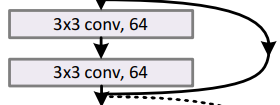

In [19]:
class ResidualBlock(Layer):
  def __init__(self, n_channels, n_strides = 1):
    super(ResidualBlock, self).__init__(name = 'res_block')

    self.dotted = (n_strides != 1)

    # CustomConv2D => 3x3 conv, 64 (ramka)
    self.custom_conv_1 = CustomConv2D(n_channels, 3, n_strides, padding = "same")
    self.custom_conv_2 = CustomConv2D(n_channels, 3, 1, padding = "same")

    self.activation = Activation('relu')

    if self.dotted:
      self.custom_conv_3 = CustomConv2D(n_channels, 1, n_strides)

  def call(self, input, training):

    x = self.custom_conv_1(input, training)
    x = self.custom_conv_2(x, training)

    if self.dotted:
      x_add = self.custom_conv_3(input, training)
      x_add = Add()([x, x_add])
    else:
      x_add = Add()([x, input])

    return self.activation(x_add)

# Complete Network -> ResNet 18-layer
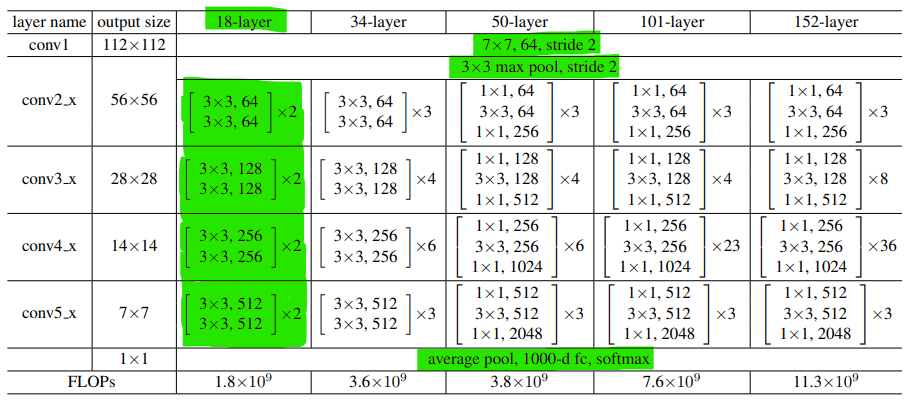

In [ ]:
class ResNet18(Model):
  def __init__(self,):
    super(ResNet34, self).__init__(name = 'resnet_34')

    self.conv_1 = CustomConv2D(64, 7, 2, padding = 'same')
    self.max_pool = MaxPooling2D(3,2)

    self.conv_2_1 = ResidualBlock(64)
    self.conv_2_2 = ResidualBlock(64)

    self.conv_3_1 = ResidualBlock(128, 2)
    self.conv_3_2 = ResidualBlock(128)

    self.conv_4_1 = ResidualBlock(256, 2)
    self.conv_4_2 = ResidualBlock(256)

    self.conv_5_1 = ResidualBlock(512, 2)
    self.conv_5_2 = ResidualBlock(512)

    self.global_pool = GlobalAveragePooling2D()

    self.fc_3 = Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')

  def call(self, x, training = True):
    x = self.conv_1(x)
    x = self.max_pool(x)

    x = self.conv_2_1(x, training)
    x = self.conv_2_2(x, training)

    x = self.conv_3_1(x, training)
    x = self.conv_3_2(x, training)

    x = self.conv_4_1(x, training)
    x = self.conv_4_2(x, training)

    x = self.conv_5_1(x, training)
    x = self.conv_5_2(x, training)

    x = self.global_pool(x)

    return self.fc_3(x)

In [ ]:
resnet_18 = ResNet18()
resnet_18(tf.zeros([1,256,256,3]), training = True)
resnet_18.summary()

# Training -> resnet_18

In [ ]:
checkpoint_callback = ModelCheckpoint(
    'best_weights',
    monitor='val_accuracy',
    mode = 'max',
    verbose=1,
    save_weights_only=True,
)

In [ ]:
loss_function = CategoricalCrossentropy()

In [ ]:
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]

In [ ]:
resnet_18.compile(
    optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']*5),
    loss = loss_function,
    metrics = metrics
)

In [ ]:
history = resnet_18.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs = CONFIGURATION["N_EPOCHS"],
    verbose = 1,
    callbacks = [checkpoint_callback],
)

# Evaluation -> resnet_18

In [ ]:
resnet_18.load_weights('best_weights')

In [ ]:
resnet_18_model = resnet_18.evaluate(validation_dataset)

# Complete Network -> ResNet 34-layer
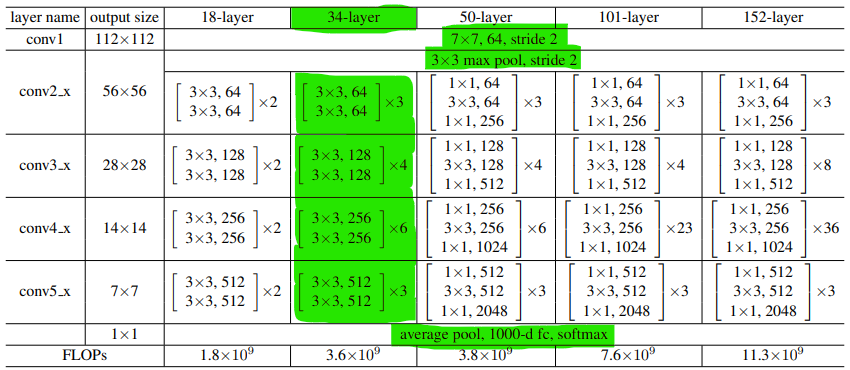

In [20]:
class ResNet34(Model):
  def __init__(self,):
    super(ResNet34, self).__init__(name = 'resnet_34')

    self.conv_1 = CustomConv2D(64, 7, 2, padding = 'same')
    self.max_pool = MaxPooling2D(3,2)

    self.conv_2_1 = ResidualBlock(64)
    self.conv_2_2 = ResidualBlock(64)
    self.conv_2_3 = ResidualBlock(64)

    self.conv_3_1 = ResidualBlock(128, 2)
    self.conv_3_2 = ResidualBlock(128)
    self.conv_3_3 = ResidualBlock(128)
    self.conv_3_4 = ResidualBlock(128)

    self.conv_4_1 = ResidualBlock(256, 2)
    self.conv_4_2 = ResidualBlock(256)
    self.conv_4_3 = ResidualBlock(256)
    self.conv_4_4 = ResidualBlock(256)
    self.conv_4_5 = ResidualBlock(256)
    self.conv_4_6 = ResidualBlock(256)

    self.conv_5_1 = ResidualBlock(512, 2)
    self.conv_5_2 = ResidualBlock(512)
    self.conv_5_3 = ResidualBlock(512)

    self.global_pool = GlobalAveragePooling2D()

    self.fc_3 = Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')

  def call(self, x, training = True):
    x = self.conv_1(x)
    x = self.max_pool(x)

    x = self.conv_2_1(x, training)
    x = self.conv_2_2(x, training)
    x = self.conv_2_3(x, training)

    x = self.conv_3_1(x, training)
    x = self.conv_3_2(x, training)
    x = self.conv_3_3(x, training)
    x = self.conv_3_4(x, training)

    x = self.conv_4_1(x, training)
    x = self.conv_4_2(x, training)
    x = self.conv_4_3(x, training)
    x = self.conv_4_4(x, training)
    x = self.conv_4_5(x, training)
    x = self.conv_4_6(x, training)

    x = self.conv_5_1(x, training)
    x = self.conv_5_2(x, training)
    x = self.conv_5_3(x, training)

    x = self.global_pool(x)

    return self.fc_3(x)

In [21]:
resnet_34 = ResNet34()
resnet_34(tf.zeros([1,256,256,3]), training = True)
resnet_34.summary()

Model: "resnet_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_conv2d (CustomConv2  multiple                  9728      
 D)                                                              
                                                                 
 max_pooling2d (MaxPooling2  multiple                  0         
 D)                                                              
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  23

# Training -> resnet_34

In [22]:
checkpoint_callback = ModelCheckpoint(
    'best_weights',
    monitor='val_accuracy',
    mode = 'max',
    verbose=1,
    save_weights_only=True,
)

In [23]:
loss_function = CategoricalCrossentropy()

In [24]:
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]

In [25]:
resnet_34.compile(
    optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']*5),
    loss = loss_function,
    metrics = metrics
)

In [ ]:
history = resnet_34.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs = CONFIGURATION["N_EPOCHS"],
    verbose = 1,
    callbacks = [checkpoint_callback],
)

Epoch 1/10
102/102 [==============================] - ETA: 0s - loss: 1.3905 - accuracy: 0.6070 - top_k_accuracy: 0.8363 
Epoch 1: saving model to best_weights
102/102 [==============================] - 2643s 26s/step - loss: 1.3905 - accuracy: 0.6070 - top_k_accuracy: 0.8363 - val_loss: 2234.9050 - val_accuracy: 0.2333 - val_top_k_accuracy: 0.9988
Epoch 2/10
102/102 [==============================] - ETA: 0s - loss: 0.6911 - accuracy: 0.7688 - top_k_accuracy: 0.9257 
Epoch 2: saving model to best_weights
102/102 [==============================] - 2611s 26s/step - loss: 0.6911 - accuracy: 0.7688 - top_k_accuracy: 0.9257 - val_loss: 10.6720 - val_accuracy: 0.4753 - val_top_k_accuracy: 0.6506
Epoch 3/10
102/102 [==============================] - ETA: 0s - loss: 0.6192 - accuracy: 0.7873 - top_k_accuracy: 0.9393 
Epoch 3: saving model to best_weights
102/102 [==============================] - 2649s 26s/step - loss: 0.6192 - accuracy: 0.7873 - top_k_accuracy: 0.9393 - val_loss: 5.9229 - va

# Train

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# Evaluation -> resnet_34

In [ ]:
resnet_34.load_weights('best_weights')

In [ ]:
resnet_34_model = resnet_34.evaluate(validation_dataset)

# Testing

In [ ]:
test_image = cv2.imread("/content/rose.jpg")

im = tf.constant(test_image, dtype = tf.float32)

im = tf.expand_dims(im, axis = 0)

print(CLASS_NAMES[tf.argmax(resnet_34(im), axis = -1).numpy()[0]])

In [ ]:
for x in validation_dataset.take(1):
  print(x)

# Exporting to Onnx format

In [ ]:
!pip install -U tf2onnx
!pip install onnxruntime as rt

In [ ]:
resnet_18.save('/content/drive/MyDrive/resnet_18_model')

In [ ]:
!python -m tf2onnx.convert --saved-model /content/drive/MyDrive/resnet_18_model/ --output resnet_18_model_onnx.onnx

In [ ]:
resnet_34.save('/content/drive/MyDrive/resnet_34_model')

In [ ]:
!python -m tf2onnx.convert --saved-model /content/drive/MyDrive/resnet_34_model/ --output resnet_34_model_onnx.onnx